# Runtime Analysis
This notebook is designed to compare output from two ACCESS-OM2 simulations - an existing reference case and a new underway simulation. The idea is to compare the two simulations over time slices which are comparable.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41002 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.67 GB


In [3]:
session = cc.database.create_session()

In [4]:
ReferenceExpt = '01deg_jra55v13_ryf9091'
UnderwayExpt = '01deg_jra55v13_ryf9091_gaditest'
NewExpt = '01deg_jra55v13_ryf9091_retest'
ReferenceName = 'RYF9091'
UnderwayName = 'Gadi Test'
NewName = 'Gadi Re-Test'
start_time = '1982-07-01'
end_time = '1984-06-30'

The Reference case (labelled RYF9091) was run on Raijin. We expect to be able to replicate this experiment on Gadi (albeit not bitwise). The diagnostics below show that salinity differs in the Underway Experiment - our first test on Gadi. We are trying to correct this with a New Experiment that I have called Gadi Re-Test... 

## Scalar diagnostics

### Global Average Temperature

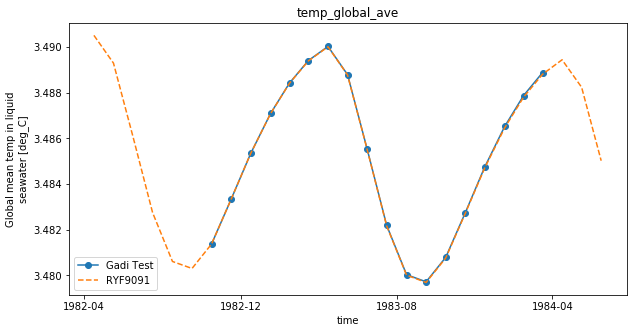

In [6]:
variable = 'temp_global_ave'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(linestyle='-',marker='o',label=UnderwayName)
#temp_new = cc.querying.getvar(NewExpt,variable,session)
#temp_new.plot(linestyle='-',marker='x',label=NewName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,start_time=start_time,end_time=end_time)
temp.plot(linestyle='--',label=ReferenceName)
plt.title(variable)
plt.legend()

### Global Average Salinity

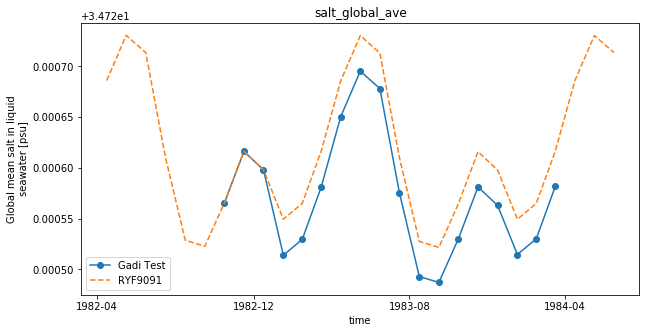

In [7]:
variable = 'salt_global_ave'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(linestyle='-',marker='o',label=UnderwayName)
#temp_new = cc.querying.getvar(NewExpt,variable,session)
#temp_new.plot(linestyle='-',marker='x',label=NewName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,start_time=start_time,end_time=end_time)
temp.plot(linestyle='--',label=ReferenceName)
plt.title(variable)
plt.legend()

### Surface Temperature

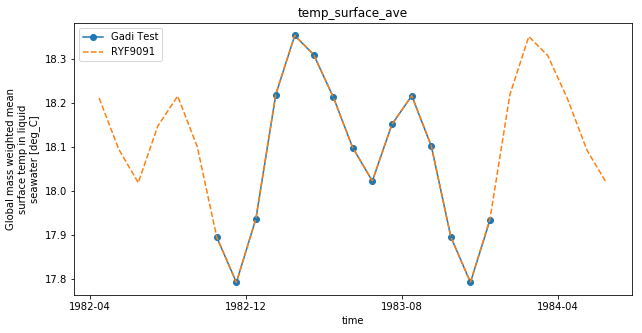

In [17]:
variable = 'temp_surface_ave'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(linestyle='-',marker='o',label=UnderwayName)
#temp_new = cc.querying.getvar(NewExpt,variable,session)
#temp_new.plot(linestyle='-',marker='x',label=NewName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,start_time=start_time,end_time=end_time)
temp.plot(linestyle='--',label=ReferenceName)
plt.title(variable)
plt.legend()

### Surface Salinity

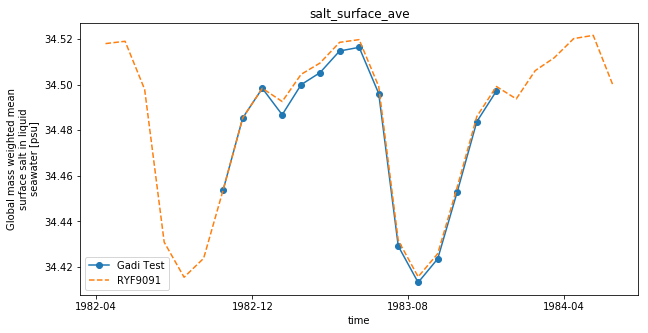

In [18]:
variable = 'salt_surface_ave'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(linestyle='-',marker='o',label=UnderwayName)
#temp_new = cc.querying.getvar(NewExpt,variable,session)
#temp_new.plot(linestyle='-',marker='x',label=NewName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,start_time=start_time,end_time=end_time)
temp.plot(linestyle='--',label=ReferenceName)
plt.title(variable)
plt.legend()

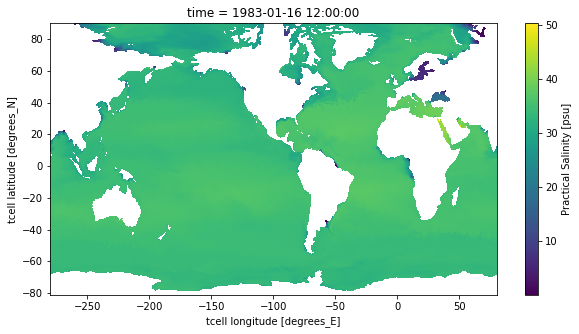

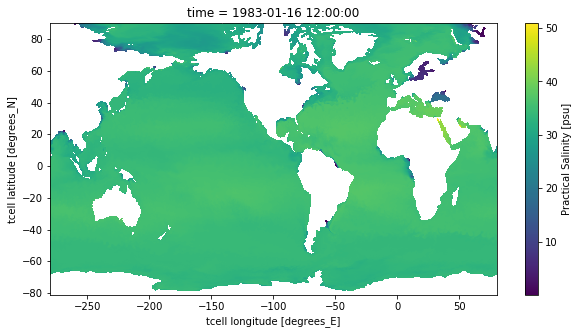

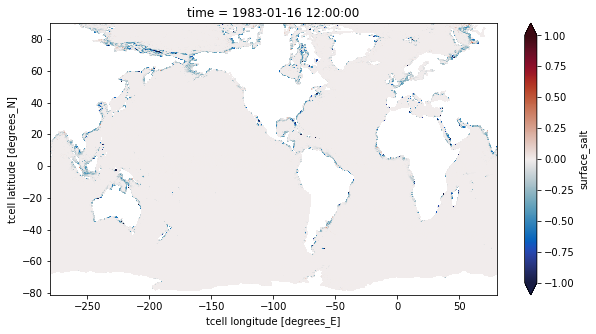

In [24]:
plt.figure(figsize=(10,5))
salt1 = cc.querying.getvar(UnderwayExpt,'surface_salt',session,ncfile='ocean_month.nc',start_time=start_time,end_time = end_time).sel(time='1983-01')
salt1.plot()
plt.figure(figsize=(10,5))
salt2 = cc.querying.getvar(ReferenceExpt,'surface_salt',session,ncfile='ocean_month.nc',start_time=start_time,end_time = end_time).sel(time='1983-01')
salt2.plot()
plt.figure(figsize=(10,5))
diff = salt1-salt2
diff.plot(vmin=-1, vmax=1,cmap=cm.cm.balance)

**This shows a pretty clear negative surface salinity change in shallow regions in the Gadi test experiment.**

### Total Kinetic Energy

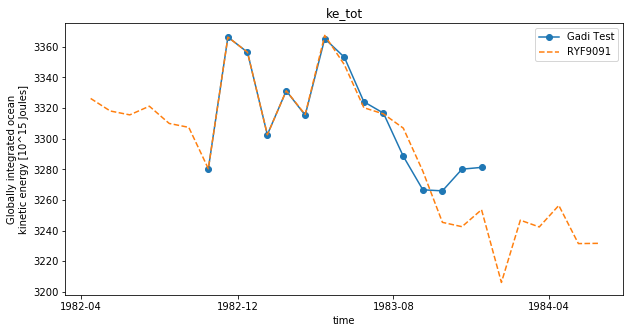

In [19]:
variable = 'ke_tot'
plt.figure(figsize=(10,5))
temp_und = cc.querying.getvar(UnderwayExpt,variable,session)
temp_und.plot(linestyle='-',marker='o',label=UnderwayName)
temp = cc.querying.getvar(ReferenceExpt,variable,session,start_time=start_time,end_time=end_time)
temp.plot(linestyle='--',label=ReferenceName)
plt.title(variable)
plt.legend()

## Area-Averaged Tracer Diagnostics

### Upper Ocean Temperature/Salinity


Text(0.5,1,'Upper Ocean Temperature (< 1000 m)')

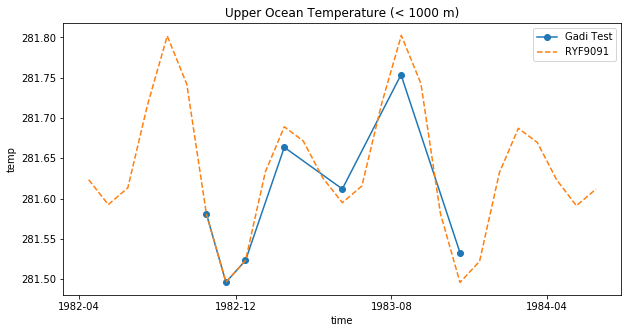

In [20]:
plt.figure(figsize=(10,5))
zlevel = 1000
temp = cc.querying.getvar(UnderwayExpt,'temp',session).sel(st_ocean = slice(0,zlevel))
temp = temp.mean('st_ocean').mean('yt_ocean').mean('xt_ocean')
temp.plot(linestyle='-',marker='o',label=UnderwayName)
temp = cc.querying.getvar(ReferenceExpt,'temp',session,start_time=start_time,end_time = end_time).sel(st_ocean = slice(0,zlevel))
temp = temp.mean('st_ocean').mean('yt_ocean').mean('xt_ocean')
temp.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('Upper Ocean Temperature (< 1000 m)')

Text(0.5,1,'Upper Ocean Salinity (< 1000 m)')

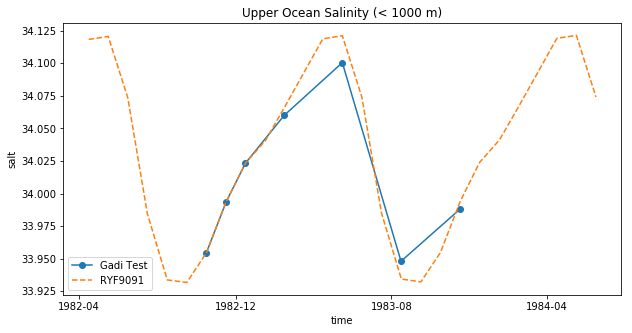

In [21]:
plt.figure(figsize=(10,5))
zlevel = 1000
salt = cc.querying.getvar(UnderwayExpt,'salt',session).sel(st_ocean = slice(0,zlevel))
salt = salt.mean('st_ocean').mean('yt_ocean').mean('xt_ocean')
salt.plot(linestyle='-',marker='o',label=UnderwayName)
salt = cc.querying.getvar(ReferenceExpt,'salt',session,start_time=start_time,end_time = end_time).sel(st_ocean = slice(0,zlevel))
salt = salt.mean('st_ocean').mean('yt_ocean').mean('xt_ocean')
salt.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('Upper Ocean Salinity (< 1000 m)')

### Deep Ocean Temperature/Salinity

Text(0.5,1,'Deep Ocean Temperature (> 3000 m)')

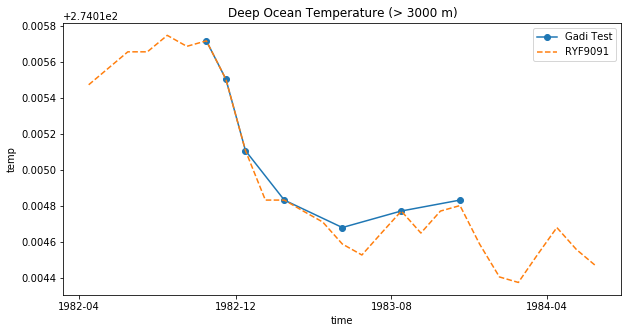

In [22]:
plt.figure(figsize=(10,5))
zlevel = 3000
temp = cc.querying.getvar(UnderwayExpt,'temp',session).sel(st_ocean = slice(zlevel,None))
temp = temp.mean('st_ocean').mean('yt_ocean').mean('xt_ocean')
temp.plot(linestyle='-',marker='o',label=UnderwayName)
temp = cc.querying.getvar(ReferenceExpt,'temp',session,start_time=start_time,end_time = end_time).sel(st_ocean = slice(zlevel,None))
temp = temp.mean('st_ocean').mean('yt_ocean').mean('xt_ocean')
temp.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('Deep Ocean Temperature (> 3000 m)')

Text(0.5,1,'Deep Ocean Salinity (> 3000 m)')

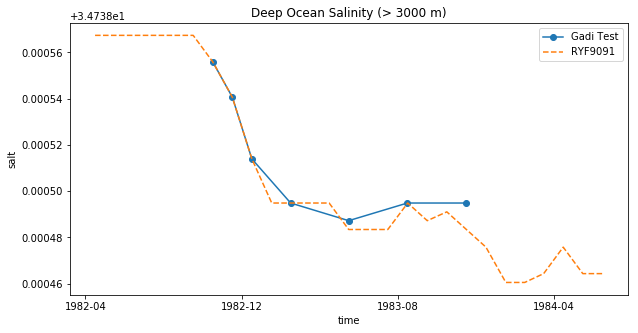

In [23]:
plt.figure(figsize=(10,5))
zlevel = 3000
salt = cc.querying.getvar(UnderwayExpt,'salt',session).sel(st_ocean = slice(zlevel,None))
salt = salt.mean('st_ocean').mean('yt_ocean').mean('xt_ocean')
salt.plot(linestyle='-',marker='o',label=UnderwayName)
salt = cc.querying.getvar(ReferenceExpt,'salt',session,start_time=start_time,end_time = end_time).sel(st_ocean = slice(zlevel,None))
salt = salt.mean('st_ocean').mean('yt_ocean').mean('xt_ocean')
salt.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('Deep Ocean Salinity (> 3000 m)')

### Ross Sea Salinity @ 350m depth

Text(0.5,1,'Salinity in SW Ross Sea')

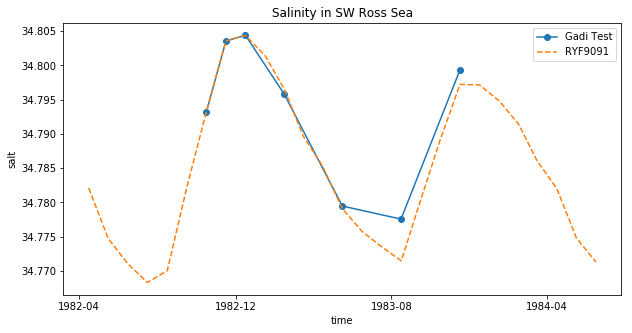

In [24]:
plt.figure(figsize=(10,5))
zlevel = 350
salt = cc.querying.getvar(UnderwayExpt,'salt',session).sel(st_ocean = zlevel,method='nearest')
salt = salt.sel(yt_ocean=slice(-78,-74)).sel(xt_ocean=slice(-195,-190)).mean('yt_ocean').mean('xt_ocean')
salt.plot(linestyle='-',marker='o',label=UnderwayName)

salt = cc.querying.getvar(ReferenceExpt,'salt',session,start_time=start_time,end_time = end_time).sel(st_ocean = zlevel,method='nearest')
salt = salt.sel(yt_ocean=slice(-78,-74)).sel(xt_ocean=slice(-195,-190)).mean('yt_ocean').mean('xt_ocean')
salt.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('Salinity in SW Ross Sea')

## Circulation Diagnostics

### Drake Passage Transport

Text(0.5,1,'ACC Transport')

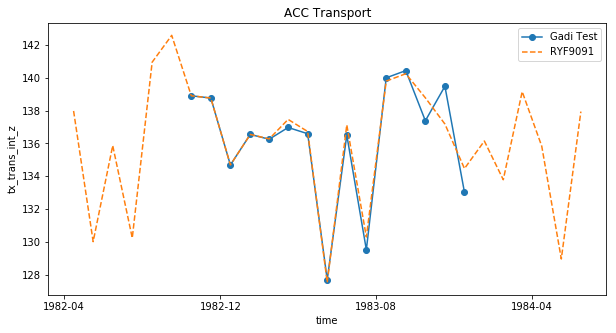

In [25]:
xmin=-69.9
ymin=-71.6
ymax=-51.0

plt.figure(figsize=(10,5))

tx_trans = cc.querying.getvar(UnderwayExpt,'tx_trans_int_z',session)
DP_und = tx_trans.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
DP_und.plot(linestyle='-',marker='o',label=UnderwayName)

tx_trans = cc.querying.getvar(ReferenceExpt,'tx_trans_int_z',session,start_time=start_time,end_time = end_time)
DP_ref = tx_trans.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
DP_ref.plot(linestyle='--',label=ReferenceName)


plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

Text(0.5,1,'AABW Cell')

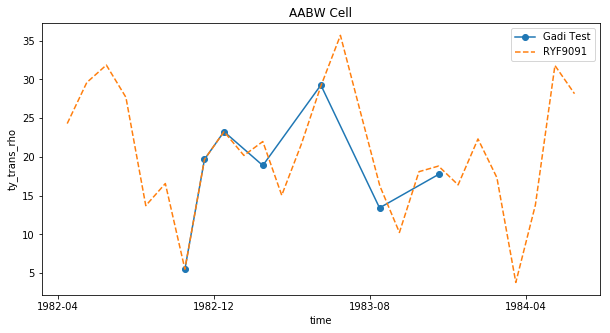

In [26]:
latitude=-55
plt.figure(figsize=(10,5))
psi = cc.querying.getvar(UnderwayExpt, 'ty_trans_rho',session)
psi_aabw = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
psi_aabw_sum.plot(linestyle='-',marker='o',label=UnderwayName)
psi = cc.querying.getvar(ReferenceExpt, 'ty_trans_rho',session,start_time=start_time,end_time = end_time)
psi_aabw = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
psi_aabw_sum.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

Text(0.5,1,'AMOC Cell')

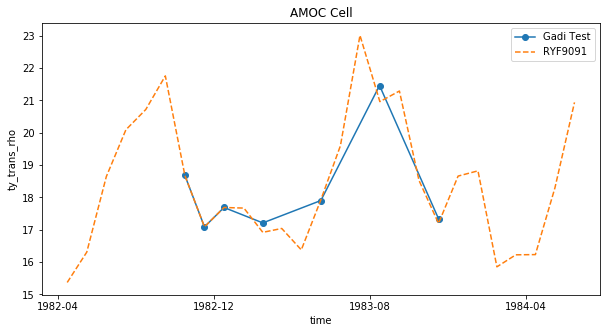

In [27]:
plt.figure(figsize=(10,5))
psi = cc.querying.getvar(UnderwayExpt, 'ty_trans_rho',session)
psi_amoc = psi.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
psi_amoc_und = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
psi_amoc_und = psi_amoc_und.sel(potrho=slice(1035.5,None)).max('potrho')
psi_amoc_und.plot(linestyle='-',marker='o',label=UnderwayName)
psi = cc.querying.getvar(ReferenceExpt, 'ty_trans_rho',session,start_time=start_time,end_time = end_time)
psi_amoc = psi.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
psi_amoc_ref = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
psi_amoc_ref = psi_amoc_ref.sel(potrho=slice(1035.5,None)).max('potrho')
psi_amoc_ref.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('AMOC Cell')

### Ice Area (in both hemispheres)

Text(0.5,1,'Southern Ocean')

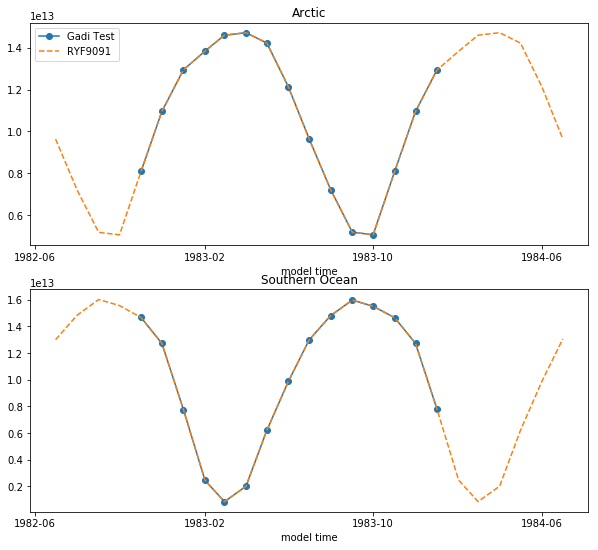

In [28]:
aice = cc.querying.getvar(UnderwayExpt, 'aice_m',session)
area_t = cc.querying.getvar(UnderwayExpt, 'area_t',session,n=1)
aice.coords['ni'] = area_t['xt_ocean'].values
aice.coords['nj'] = area_t['yt_ocean'].values
aice = aice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
area_und = aice*area_t
area_und_zonalsum = area_und.sum('xt_ocean').load()

aice = cc.querying.getvar(ReferenceExpt, 'aice_m',session,start_time=start_time,end_time = end_time)
area_t = cc.querying.getvar(ReferenceExpt, 'area_t',session,n=1)
aice = aice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
area_ref = aice*area_t
area_ref_zonalsum = area_ref.sum('xt_ocean').load()

plt.figure(figsize=(10,9))
plt.subplot(211)
NH_area_und = area_und_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
NH_area_und.plot(linestyle='-',marker='o',label=UnderwayName)
NH_area_ref = area_ref_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
NH_area_ref.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('Arctic')

plt.subplot(212)
SH_area_und = area_und_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
SH_area_und.plot(linestyle='-',marker='o',label=UnderwayName)
SH_area_ref = area_ref_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
SH_area_ref.plot(linestyle='--',label=ReferenceName)
plt.title('Southern Ocean')

### Ice volume (in both hemispheres)

Text(0.5,1,'Southern Ocean')

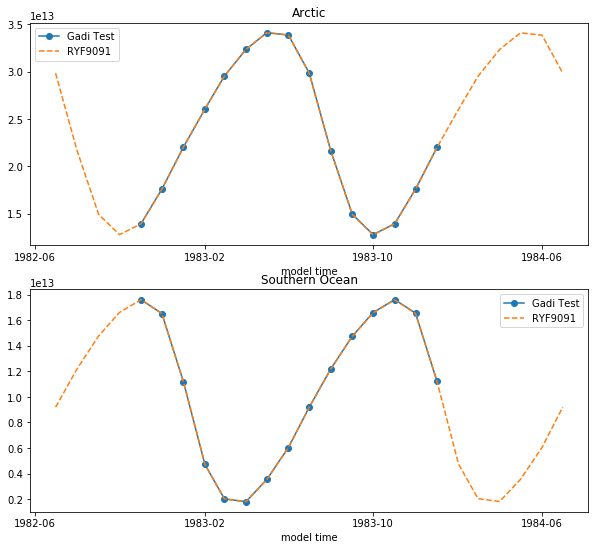

In [29]:
vicen_und = cc.querying.getvar(UnderwayExpt, 'vicen_m',session)
area_t_und = cc.querying.getvar(UnderwayExpt, 'area_t',session,n=1)
vicen_und.coords['ni'] = area_t_und['xt_ocean'].values
vicen_und.coords['nj'] = area_t_und['yt_ocean'].values
vicen_und = vicen_und.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
vol_und = vicen_und*area_t_und
vol_und_zonalsum = vol_und.sum('xt_ocean').sum('nc').load()

vicen_ref = cc.querying.getvar(ReferenceExpt, 'vicen_m',session,start_time=start_time,end_time = end_time)
area_t_ref = cc.querying.getvar(ReferenceExpt, 'area_t',session,n=1)
vicen_ref.coords['ni'] = area_t_ref['xt_ocean'].values
vicen_ref.coords['nj'] = area_t_ref['yt_ocean'].values
vicen_ref = vicen_ref.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
vol_ref = vicen_ref*area_t_ref
vol_ref_zonalsum = vol_ref.sum('xt_ocean').sum('nc').load()

plt.figure(figsize=(10,9))
plt.subplot(211)
NH_vol_und = vol_und_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
NH_vol_und.plot(linestyle='-',marker='o',label=UnderwayName)
NH_vol_ref = vol_ref_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
NH_vol_ref.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('Arctic')

plt.subplot(212)
SH_vol_und = vol_und_zonalsum.sel(yt_ocean=slice(-90, 0)).sum('yt_ocean')
SH_vol_und.plot(linestyle='-',marker='o',label=UnderwayName)
SH_vol_ref = vol_ref_zonalsum.sel(yt_ocean=slice(-90, 0)).sum('yt_ocean')
SH_vol_ref.plot(linestyle='--',label=ReferenceName)
plt.legend()
plt.title('Southern Ocean')